# ATLAS: Analysis of STructuraL Variation Across Species

# Introduction

<span style="background-color:#66FF99">**Here is the final stage of the GEM-PRO workflow. In this notebook, we will look at how the mutations are distributed throughout the strains, with the additional knowledge of their structural characteristics.**</span>

Here are some of the questions we will ask in this notebook:

1. Is there variation that is shared across strains? 
2. Are the variant amino acids clustered within in the same vicinity (within 5-10 Angstroms of one another)?
3. Is variation more on the surface or in buried regions? 
4. What kind of mutation is occuring (i.e. negative to positive charge at the surface, etc)
5. Where in reference to the active site does variation occur in the protein? [optional]
6. Does it impact catalytic residues? [optional]

In [70]:
%run 'ssbio_01.ipynb'

INFO:.prody:ProDy is configured: verbosity='none'


In [294]:
%run 'ssbio_04.ipynb'

In [263]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 5)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels
from statsmodels.nonparametric.kde import *
# from statsmodels.nonparametric.kde import KDE   # version 0.5.0
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.formula.api import logit, glm
from operator import add

In [196]:
GEM_NAME = 'iJO1366'
GEM_GENE_SOURCE = 'ENSEMBLGENOME_ID'
UNIPROT_REVIEWED_ONLY = True
ROOT_DIR = os.getcwd()

In [87]:
MODEL_DIR = os.path.join(ROOT_DIR, GEM_NAME)

# data_frames - directory where all data frames will be stored (all stages)
DATA_FRAMES = os.path.join(MODEL_DIR, 'data_frames')

# model_files - directory where original GEMs and GEM-related files are stored
MODEL_FILES = os.path.join(MODEL_DIR, 'model_files')

# sequence_files - directory where all sequence related files are stored
SEQ_FILES = os.path.join(MODEL_DIR, 'sequence_files')
SEQ_UNIPROT_FILES = os.path.join(SEQ_FILES, 'uniprot_sequences')
SEQ_PDB_FILES = os.path.join(SEQ_FILES, 'pdb_sequences')
SEQ_ALIGN_FILES = os.path.join(SEQ_FILES, 'alignment')

# structure_files - directory where structure related files will be downloaded/are located
STRUCT_FILES = os.path.join(MODEL_DIR, 'structure_files/best_set/combined/')

# Load structural properties combined with strain mutation information

In [64]:
DF_PROPERTIES = pd.read_csv('55_STRAINS/DF_MUT_PROPS.csv', index_col = 0)
DF_PROPERTIES.head(3)

,gene,res,strains,strainlist,R,H,K,D,E,S,T,N,Q,C,U,Y,P,G,A,I,L,M,F,W,V,X,positive,negative,polar,nonpolar,unknown,syslist,sasa,redepth,sstructure,CM,EP,IP,SG,per_CM,per_EP,per_IP,per_SG,i_entry_name,pdb_file
0,b0003,274,37,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,0,37,-37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,['Threonine and Lysine Metabolism'],158,1.73440,H,0.10811,0.40541,0.29730,0.18919,0.44444,0.9375,1.00000,1.00000,KHSE_ECOLI,KHSE_ECOLI_model1.pdb
1,b0004,237,38,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,0,0,0,0,-38,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,-38,38,0,"['Cofactor and Prosthetic Group Biosynthesis',...",25,2.57759,T,0.10526,0.42105,0.28947,0.18421,0.44444,1.0000,1.00000,1.00000,THRC_ECOLI,THRC_ECOLI_model1.pdb
2,b0026,849,33,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,0,0,0,-33,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,-33,33,0,['tRNA Charging'],21,1.88349,-,0.12121,0.48485,0.21212,0.18182,0.44444,1.0000,0.63636,0.85714,SYI_ECOLI,SYI_ECOLI_model1.pdb


___________________

# Question #1

<span style="background-color:#66FF99">**Is there variation that is shared across strains?**</span>

#### Dictionary of all 55 strains and their grouping (by niche/pathogen)

Each of the 55 strains is assigned a pathotype, according to where it is found in the body and its general role in health

In [26]:
strandict

{'iAPECO1_1312': 'EP',
 'iBWG_1329': 'CM',
 'iE2348C_1286': 'EP',
 'iEC042_1314': 'EP',
 'iEC55989_1330': 'IP',
 'iECABU_c1320': 'EP',
 'iECB_1328': 'CM',
 'iECDH10B_1368': 'CM',
 'iECDH1ME8569_1439': 'CM',
 'iECH74115_1262': 'IP',
 'iECIAI1_1343': 'IP',
 'iECIAI39_1322': 'EP',
 'iECNA114_1301': 'EP',
 'iECO103_1326': 'IP',
 'iECO111_1330': 'IP',
 'iECO26_1355': 'IP',
 'iECOK1_1307': 'EP',
 'iECP_1309': 'EP',
 'iECS88_1305': 'EP',
 'iECSE_1348': 'IP',
 'iECSF_1327': 'EP',
 'iECSP_1301': 'IP',
 'iECUMN_1333': 'EP',
 'iECs_1301': 'IP',
 'iETEC_1333': 'CM',
 'iEcDH1_1363': 'CM',
 'iEcE24377_1341': 'IP',
 'iEcSMS35_1347': 'EP',
 'iEcolC_1368': 'CM',
 'iG2583_1286': 'IP',
 'iJO1366': 'CM',
 'iLF82_1304': 'EP',
 'iNRG857_1313': 'EP',
 'iSBO_1134': 'SG',
 'iSDY_1059': 'SG',
 'iSFV_1184': 'SG',
 'iSFxv_1172': 'SG',
 'iSSON_1240': 'SG',
 'iS_1188': 'SG',
 'iSbBS512_1146': 'SG',
 'iUMNK88_1353': 'CM',
 'iUTI89_1310': 'EP',
 'ic_1306': 'EP'}

#### Plot the number of strains (y-axis) that differ from K12 in the same gene (x-axis)

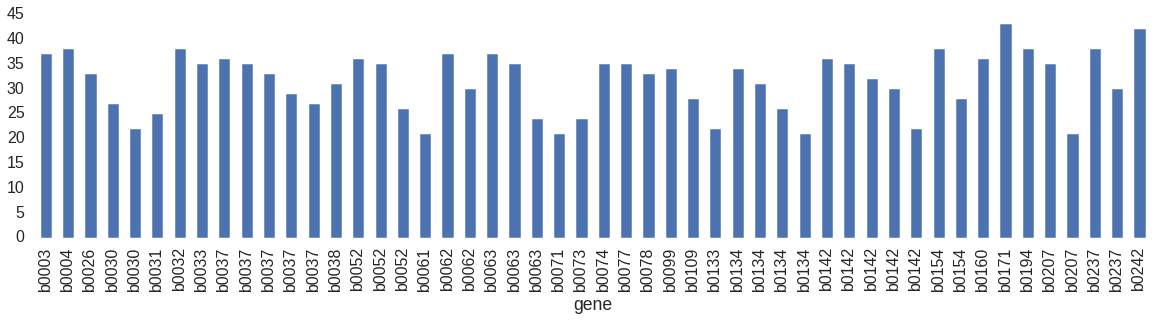

In [44]:
fig,ax = plt.subplots(figsize=(20,4))

df = DF_PROPERTIES[['strains','gene']].drop_duplicates()

df= df[df.strains > 20][0:50].set_index('gene')

df.plot(kind='bar',ax=ax,legend=False)

#### What kind of structural elements does amino acid variation occur in?

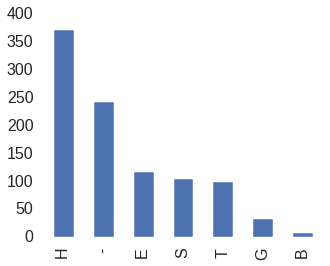

In [52]:
df = pd.DataFrame(DF_PROPERTIES[['gene','strains','syslist']].drop_duplicates().gene.value_counts())
df3 = pd.DataFrame(DF_PROPERTIES[DF_PROPERTIES.gene.isin(df[df['gene']>=1].index.tolist())][['gene','strains','sstructure']].sstructure.value_counts())
fig,ax = plt.subplots(figsize=(5,4))
df3.plot(kind='bar',ax=ax,legend=False)

#### Query specific genes to see how specific strain-types vary with respect to K12 (e.g. b0349)

For b0349, we see that the majority of strains that share variation in this gene belong to the same pathotype (50% of the total strains are interintestinal pathogens)

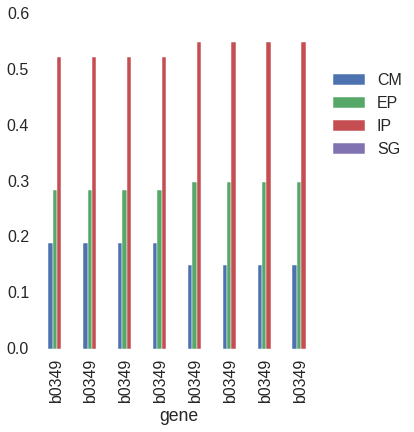

In [55]:
df = pd.DataFrame(DF_PROPERTIES[['gene','strains','syslist']].gene.value_counts())

df3 = pd.DataFrame(DF_PROPERTIES[DF_PROPERTIES.gene.isin(df[df['gene']>=1].index.tolist())][['gene','res','CM','EP','IP','SG']].drop_duplicates())
fig,ax = plt.subplots(figsize=(5,6))
df3[df3.gene == 'b0349'][['gene','CM','EP','IP','SG']].set_index('gene').plot(kind = 'bar',ax=ax,legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.7))

Look across all genes, across pathotypes at variation between wild-type and K12

* Note: on the x-axis is the number of amino acids that differ between wild-type and K12
    * The colors green, red, blue and purple for E. pec, I. Pec, commensal, shigella, respectively

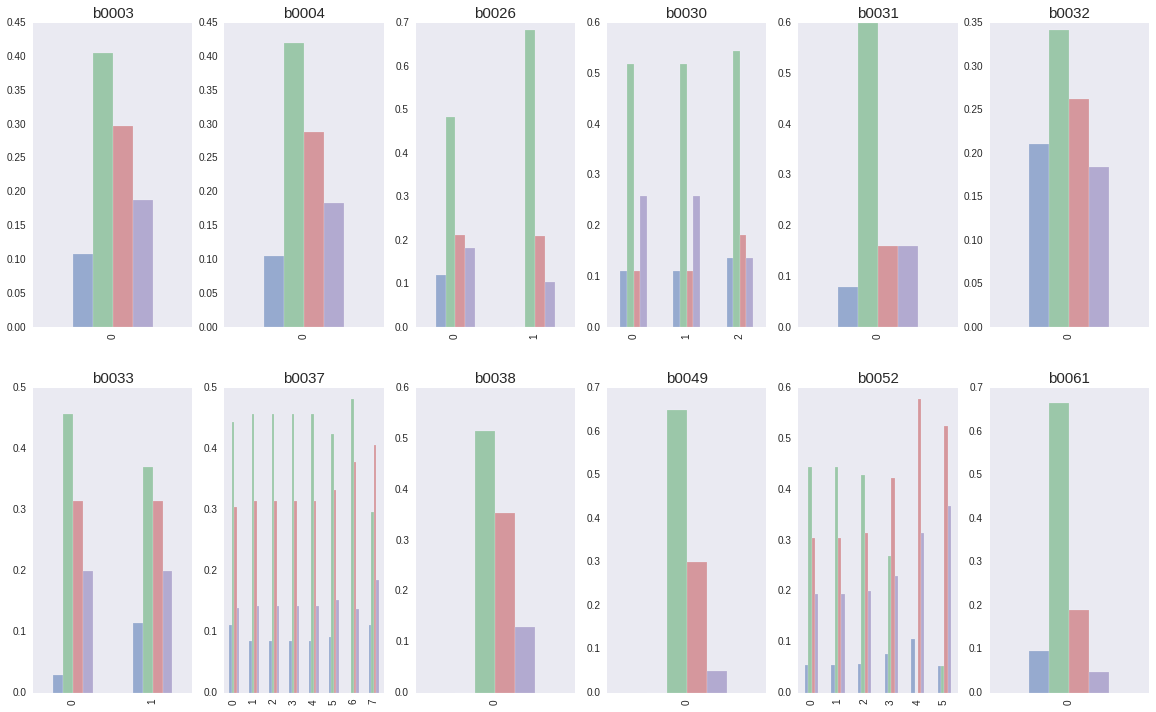

In [220]:
df = pd.DataFrame(DF_PROPERTIES[['gene','strains','syslist']].gene.value_counts())

df3 = pd.DataFrame(DF_PROPERTIES[DF_PROPERTIES.gene.isin(df[df['gene']>=1].index.tolist())][['gene','res','CM','EP','IP','SG']].drop_duplicates())

# lets take a subset of this dataframe, since its pretty big. You can comment out the below line to see all genes
df3 = df3.head(30)

list_genes = df3.gene.unique().tolist()

# Note: to see all genes, change figsize=(20,20)) to figsize=(20,120))            
fig, axes = plt.subplots(nrows=int(np.round(np.true_divide(len(list_genes),6))), ncols=6, figsize=(20,12));
rc={'axes.labelsize': 12, 'font.size': 10, 'legend.fontsize': 10.0, 'axes.titlesize': 10}
sns.set(rc=rc)
k=0
af=axes.flatten()
for a in af:
    if k < len(list_genes):
        r = list_genes[k]
        df = df3[df3.gene == r][['CM','EP','IP','SG']].reset_index()       
        df[['CM','EP','IP','SG']].plot(kind = 'bar', ax=a, alpha=0.53,legend=False)
        a.grid(False);
        k=k+1
            
        #a.set_ylabel("percent", fontsize=10) 
        #a.set_xlabel("gene", fontsize=10)
        a.set_title(r, fontsize=15)

________________

# Question #2

<span style="background-color:#66FF99">**Are the variant amino acids clustered within in the same vicinity (within 5-10 Angstroms of one another)?**</span>

#### Plot all genes with at least three amino acids that differ from K12

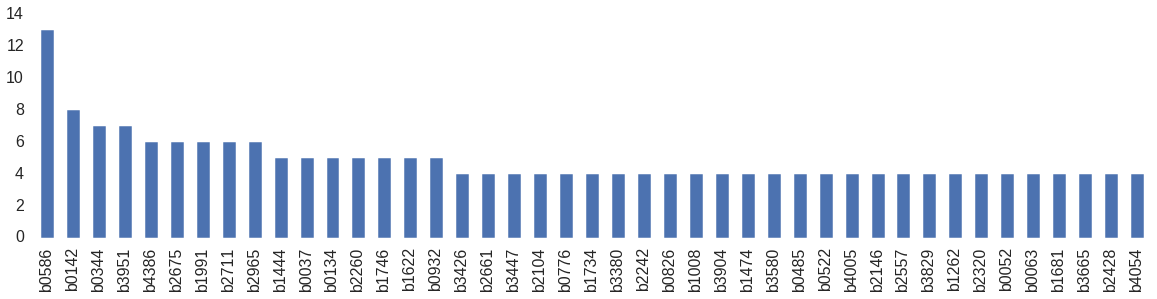

In [42]:
fig,ax = plt.subplots(figsize=(20,4))
df = pd.DataFrame(DF_PROPERTIES[['gene','strains','syslist']].drop_duplicates().gene.value_counts())
df

df[df['gene']>3].plot(kind='bar',ax=ax,legend=False)

#### Load GEM-PRO for E coli

In [102]:
DF_GEM_PRO_EC = pd.read_pickle(os.path.join(DATA_FRAMES, 'DF_03_GEMPRO_pub.pckl'))
DF_GEM_PRO_EC.head(3)

,m_reaction,m_subsystem,m_formula,m_metabolites,m_gene_reaction_rule,m_gene,u_uniprot_acc,u_reviewed,u_gene_name,u_ec_number,u_description,u_seq,u_seq_len,u_pfam,u_kegg_id,u_refseq,u_go,u_pdb_count,u_pdb,p_experiment,p_resolution,p_chemicals,p_chains,p_chain_uniprot_map,p_ec_numbers,p_deposition_date,p_doi,p_pmid,p_space_group,i_entry_name,i_length,i_native,i_tm_helix,i_tm_score,i_url,i_label,i_model_type,ssb_p_aln_score,ssb_p_aln_coverage,ssb_p_percent_seq_ident,ssb_p_no_deletions_in_pdb,ssb_p_aln_coverage_sim,normalized,ssb_si_score,ssb_p_chains_from_org,ssb_p_alpha_beta_comp,ssb_alpha_beta_diff_abs,ssb_alpha_beta_diff,ssb_alpha_beta_res_sim,ssb_alpha_beta_res_sim_score,p_resolution_scaled,ssb_rez_score,ssb_raw_score,ssb_above_cutoffs,ssb_rank,ssb_i_alpha_comp,ssb_i_beta_comp,ssb_i_alpha_beta_comp,ssb_best_file
0,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"['12ppd_DASH_R_e', '12ppd_DASH_R_p']",(b0241 or b0929 or b1377 or b2215),b0241,P02932,True,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:Y75_p0232', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'YP_488536.1', ...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,http://zhanglab.ccmb.med.umich.edu/QUARK/ecoli...,E12496,template-based,1710,330,0.94017,True,330,0.88983,1.12501,True,0.57576,0.0202,0.0202,0.35019,0.69835,0.92217,1,2.82335,False,NaN,0.01994,0.53561,0.55556,PHOE_ECOLI_model1.pdb
1,12PPDStex,"Transport, Outer Membrane Porin",12ppd_DASH_S_e <=> 12ppd_DASH_S_p,"['12ppd_DASH_S_e', '12ppd_DASH_S_p']",(b0241 or b0929 or b1377 or b2215),b0241,P02932,True,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:Y75_p0232', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'YP_488536.1', ...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,http://zhanglab.ccmb.med.umich.edu/QUARK/ecoli...,E12496,template-based,1710,330,0.94017,True,330,0.88983,1.12501,True,0.57576,0.0202,0.0202,0.35019,0.69835,0.92217,1,2.82335,False,NaN,0.01994,0.53561,0.55556,PHOE_ECOLI_model1.pdb
2,23CAMPtex,"Transport, Outer Membrane Porin",23camp_e <=> 23camp_p,"['23camp_e', '23camp_p']",(b0241 or b0929 or b1377 or b2215),b0241,P02932,True,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:Y75_p0232', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'YP_488536.1', ...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,http://zhanglab.ccmb.med.umich.edu/QUARK/ecoli...,E12496,template-based,1710,330,0.94017,True,330,0.88983,1.12501,True,0.57576,0.0202,0.0202,0.35019,0.69835,0.92217,1,2.82335,False,NaN,0.01994,0.53561,0.55556,PHOE_ECOLI_model1.pdb


#### Look up information in GEM-PRO by querying with a given gene (bnumber)

The below scripts make use of sequence alignments between PDB and uniprot sequences in order to locate residues that correspond to eachother. 

#### Why might there be a difference between uniprot and PDB sequence?

In [180]:
# EXAMPLE Script- model test

test1_id = 'test1'
test1_seq = 'AGLTQVYADNIHFMKSPREL'
test2_id = 'test2'
test2_seq = 'XXXXXXXAGLTQVYADNIHFMKSPREL'

# get the alignment dataframe (see below for entire df)
alignment_df = run_alignment2(test1_id, test1_seq, test2_id, test2_seq)

# get the position of test1's residue 20 in test2
print 'TEST1 RESIDUE 20 -> TEST2 RESIDUE', get_corresponding_resnum(alignment_df, test1_id, 20, test2_id)

# you can also do the opposite (get the position of test2's residue 27 in test1)
print 'TEST2 RESIDUE 27 -> TEST1 RESIDUE', get_corresponding_resnum(alignment_df, test2_id, 27, test1_id)

TEST1 RESIDUE 20 -> TEST2 RESIDUE 27
TEST2 RESIDUE 27 -> TEST1 RESIDUE 20


In the below script, we link all amino acid variants to their structural PDB residue ID's in order to map structural properties to this dataframe

In [160]:
read_to_struct = []
df = DF_PROPERTIES

for i in DF_PROPERTIES.index:
    uniprot_id = DF_GEM_PRO_EC[DF_GEM_PRO_EC.m_gene==df.gene[i]].u_uniprot_acc.unique().tolist()
    pdb_id_main = df[df.gene==df.gene[i]].pdb_file.unique().tolist()
    uniprot_res = int(df.res[i]-1)
    
    if len(uniprot_id) > 0:
        uniprot_id = uniprot_id[0]
        uniprot_seq = DF_GEM_PRO_EC[DF_GEM_PRO_EC.m_gene==df.gene[i]].u_seq.unique().tolist()[0]
        if len(pdb_id_main) > 0:
            pdb_id_main = pdb_id_main[0]+''
            temp = get_struct_faa(STRUCT_FILES, pdb_id_main)
            pdb_seq = temp[0]
            file_path = temp[2]
            if pdb_seq != None:
                alignment_df = run_alignment2(uniprot_id, uniprot_seq, pdb_id_main, pdb_seq)
                try:   # NATHAN MIH to look at-- I believe the DF_PRPERTIES.csv has errors
                    pdb_res = get_corresponding_resnum(alignment_df, pdb_id_main, uniprot_res, uniprot_id)
                except IndexError:
                    pdb_res=np.nan
            else:
                pdb_res = np.nan
            
        else:
            pdb_id_main = np.nan   
    else:
        uniprot_id = np.nan
        if len(pdb_id_main) > 0:
            pdb_id_main = pdb_id_main[0]
            print "deal with this--"
        else:
            pdb_id_main = np.nan
            pdb_res = np.nan
            
    if pd.notnull(pdb_res):   
        read_to_struct.append({'gene':df.gene[i],'u_uniprot_acc':uniprot_id, 'u_uniprot_aa':float(uniprot_res)+1, 
                               'u_uniprot_res':uniprot_seq[int(uniprot_res)], 'pdb_file':pdb_id_main, 
                               'p_pdb_aa':float(pdb_res)+1, 'p_pdb_res':pdb_seq[int(pdb_res)]})
        
pd.DataFrame(read_to_struct)

,gene,p_pdb_aa,p_pdb_res,pdb_file,u_uniprot_aa,u_uniprot_acc,u_uniprot_res
0,b0003,274,E,KHSE_ECOLI_model1.pdb,274,P00547,E
1,b0004,237,T,THRC_ECOLI_model1.pdb,237,P00934,T
2,b0026,849,S,SYI_ECOLI_model1.pdb,849,P00956,S
3,b0026,227,A,SYI_ECOLI_model1.pdb,227,P00956,A
4,b0030,206,Q,RIHC_ECOLI_model1.pdb,206,P22564,Q
5,b0030,202,S,RIHC_ECOLI_model1.pdb,202,P22564,S
6,b0030,304,S,RIHC_ECOLI_model1.pdb,304,P22564,S
7,b0031,69,V,DAPB_ECOLI_model1.pdb,69,P04036,V
8,b0033,434,D,CARB_ECOLI_model1.pdb,434,P00968,D
9,b0033,487,D,CARB_ECOLI_model1.pdb,487,P00968,D


In [204]:
DF_sequence_structure = pd.DataFrame(read_to_struct)
DF_PROPERTIES_merged = pd.merge(DF_sequence_structure,DF_PROPERTIES, left_on=['gene','u_uniprot_aa','pdb_file'], right_on=['gene','res','pdb_file'])

#### Now, calculate distances between two amino acids in a gene

Example- calculate the residue distance between any two mutations


In [179]:
gene= 'b1136'
calculate_res_distance(gene, 398, 414, DF_PROPERTIES, STRUCT_FILES)

(398, 'D', 414, 'E', 21.493559611327097, 416)

Example two: use the DF_sequence_structure dataframe and DF_Properties to query structural properties about amino acid variants


In [205]:
DF_PROPERTIES[DF_PROPERTIES.gene == 'b1136']

,gene,res,strains,strainlist,R,H,K,D,E,S,T,N,Q,C,U,Y,P,G,A,I,L,M,F,W,V,X,positive,negative,polar,nonpolar,unknown,syslist,sasa,redepth,sstructure,CM,EP,IP,SG,per_CM,per_EP,per_IP,per_SG,i_entry_name,pdb_file
285,b1136,398,40,"['iAPECO1_1312', 'iBWG_1329', 'ic_1306', 'iE23...",0,0,0,-40,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,['Citric Acid Cycle'],148,1.67213,S,0.15000,0.40000,0.27500,0.17500,0.66667,1,1,1.00000,IDH_ECOLI,IDH_ECOLI_model1.pdb
286,b1136,414,33,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,33,0,-33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,-33,0,0,0,['Citric Acid Cycle'],147,1.80042,H,0.06061,0.48485,0.33333,0.12121,0.22222,1,1,0.57143,IDH_ECOLI,IDH_ECOLI_model1.pdb


In [206]:
res = [int(i) for i in DF_PROPERTIES_merged[DF_PROPERTIES_merged.gene == 'b1136'].res.tolist()]

In [207]:
calculate_res_distance('b1136', res[0], res[1], DF_PROPERTIES, STRUCT_FILES)

(398, 'D', 414, 'E', 21.493559611327097, 416)

Example three: double check uniprot/PDB sequences

In [208]:
DF_PROPERTIES_merged[DF_PROPERTIES_merged.gene=='b1136'][DF_PROPERTIES_merged.res.isin(res)]

,gene,p_pdb_aa,p_pdb_res,pdb_file,u_uniprot_aa,u_uniprot_acc,u_uniprot_res,res,strains,strainlist,R,H,K,D,E,S,T,N,Q,C,U,Y,P,G,A,I,L,M,F,W,V,X,positive,negative,polar,nonpolar,unknown,syslist,sasa,redepth,sstructure,CM,EP,IP,SG,per_CM,per_EP,per_IP,per_SG,i_entry_name
266,b1136,398,D,IDH_ECOLI_model1.pdb,398,P08200,D,398,40,"['iAPECO1_1312', 'iBWG_1329', 'ic_1306', 'iE23...",0,0,0,-40,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,['Citric Acid Cycle'],148,1.67213,S,0.15000,0.40000,0.27500,0.17500,0.66667,1,1,1.00000,IDH_ECOLI
267,b1136,414,E,IDH_ECOLI_model1.pdb,414,P08200,E,414,33,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,33,0,-33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,-33,0,0,0,['Citric Acid Cycle'],147,1.80042,H,0.06061,0.48485,0.33333,0.12121,0.22222,1,1,0.57143,IDH_ECOLI


#### Generate distance matrix for all genes in DF_PROPERTIES_merged

In [213]:
DF_1_vicinity_mutations = generate_distance_matrices(STRUCT_FILES,DF_PROPERTIES_merged)

DF_1_vicinity_mutations.head(2)

,gene,pdb,chainA,chainB,locationA,locationB,resA,resB,distance
0,b0030,pdb_chain_uniprot.csv.gz,X,X,202,206,SER,GLN,7.04130
1,b0030,pdb_chain_uniprot.csv.gz,X,X,202,304,SER,SER,17.49422


plot the results

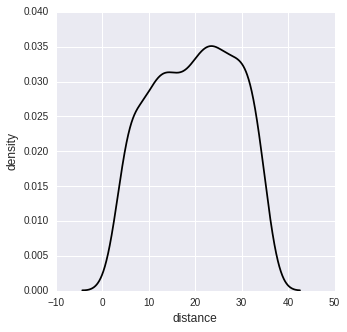

In [234]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(5, 5))
d=DF_1_vicinity_mutations.distance.values.tolist()
d_kde = statsmodels.nonparametric.kde.KDEUnivariate(d)
#d_kde = KDE(d)   # version 0.5.0
d_kde.fit()
# Sort inside the plotting so the lines connect nicely.
plt.plot(d_kde.support, d_kde.density,color='black', label = 'density',axes=axes)
axes.set(xlabel="distance", ylabel="density")

In this case, amino acid differences within a given gene span distances from nearly 0 to 40 angstroms. 

__________________________

# Question #3

<span style="background-color:#66FF99">**Is variation more on the surface or in buried regions?**</span>

Load a pre-calculated MSMS dataframe (see stage 3 script for a workflow on attaining this dataframe)

In [251]:
DF_MSMS = pd.read_csv(DATA_FRAMES+'/ECOgenemsms.csv',index_col=0)
DF_MSMS.head(3)

,pdbname,msms,gene
0,GHRB_ECOLI_model1.pdb,"[['X', 1, 1.8483246856867441, 2.14966736707222...",b3553
1,COF_ECOLI_model1.pdb,"[['X', 1, 1.8831744572983624, 2.19144845017260...",b0446
2,RUTD_ECOLI_model1.pdb,"[['X', 1, 1.8296129586546017, 1.99958966190969...",b1009


#### Compute residue depth, given a gene and a specific amino acid residue number

In [252]:
# Example script to find residue depth:
# prints: residue depth (considering all atoms in residue), alpha carbon residue depth

find_residue_depth(398, 'b1136', DF_MSMS)

(1.6720789655561683, 1.9996114952827095)

It will make things easier to work with a "merged" pandas dataframe, here I just merge the above residue depth df with our DF_PROPERTIES_merged

In [253]:
read_to_struct = []
for i in DF_PROPERTIES_merged.index:
    gene = DF_PROPERTIES_merged.gene[i]
    res = DF_PROPERTIES_merged.p_pdb_aa[i]
    
    read_to_struct.append({'gene':gene,'p_pdb_aa':res,'ca_res_depth':find_residue_depth(res, gene, DF_MSMS)[1]})

DF_PROPERTIES_merged_RD = pd.merge(DF_PROPERTIES_merged,pd.DataFrame(read_to_struct),on=['gene','p_pdb_aa'])
DF_PROPERTIES_merged_RD.head(3)

,gene,p_pdb_aa,p_pdb_res,pdb_file,u_uniprot_aa,u_uniprot_acc,u_uniprot_res,res,strains,strainlist,R,H,K,D,E,S,T,N,Q,C,U,Y,P,G,A,I,L,M,F,W,V,X,positive,negative,polar,nonpolar,unknown,syslist,sasa,redepth,sstructure,CM,EP,IP,SG,per_CM,per_EP,per_IP,per_SG,i_entry_name,ca_res_depth
0,b0003,274,E,KHSE_ECOLI_model1.pdb,274,P00547,E,274,37,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,0,37,-37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,['Threonine and Lysine Metabolism'],158,1.73440,H,0.10811,0.40541,0.29730,0.18919,0.44444,0.9375,1.00000,1.00000,KHSE_ECOLI,1.99972
1,b0004,237,T,THRC_ECOLI_model1.pdb,237,P00934,T,237,38,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,0,0,0,0,-38,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,-38,38,0,"['Cofactor and Prosthetic Group Biosynthesis',...",25,2.57759,T,0.10526,0.42105,0.28947,0.18421,0.44444,1.0000,1.00000,1.00000,THRC_ECOLI,1.99968
2,b0026,849,S,SYI_ECOLI_model1.pdb,849,P00956,S,849,33,"['iAPECO1_1312', 'ic_1306', 'iE2348C_1286', 'i...",0,0,0,0,0,-33,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,-33,33,0,['tRNA Charging'],21,1.88349,-,0.12121,0.48485,0.21212,0.18182,0.44444,1.0000,0.63636,0.85714,SYI_ECOLI,2.30569


#### Now that we have all residue depths for residues in our DF_PROPERTIES dataframe, we can plot!

The plot below shows a density function that indicates how much variation occurs at the surface compared to buried regions (note: the smaller the value on the x-axis, the closer to the surface a residue is). We also create a probability distribution function to understand whether a particular change in amino acid residue is expected, as a function of its relative position in the protein.

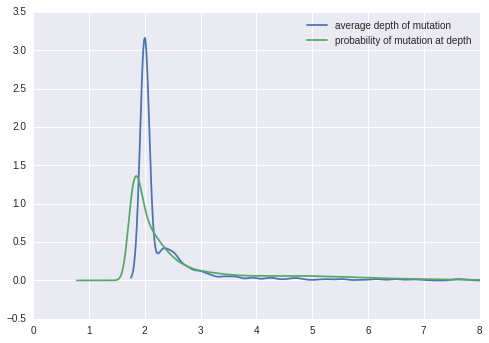

In [258]:
red=[]
df = DF_PROPERTIES_merged_RD

# gets information to compute probability of observing 
# variation in an amino acid at a specific region of a protein
for i in [x for x in DF_MSMS.msms]:
    for j in eval(i):
        red.append(j[2])

df.ca_res_depth=df.ca_res_depth.astype(float)
d=df.ca_res_depth.values.tolist()
d_kde = statsmodels.nonparametric.kde.KDEUnivariate(d)
p_kde = statsmodels.nonparametric.kde.KDEUnivariate(red)
d_kde.fit()
p_kde.fit()
# Sort inside the plotting so the lines connect nicely.
fig = plt.figure()
plt.plot(d_kde.support, d_kde.density, label = 'average depth of mutation')
plt.plot(p_kde.support, p_kde.density, label = 'probability of mutation at depth')
plt.xlim(0,8)
plt.legend()

-----------------------

# Question #4 

In this section, we will make use of this slice of the DF_PROPERTIES_merged_RD dataframe:

In [289]:
DF_PROPERTIES_merged_RD.ix[:,10:37][0:1]

,R,H,K,D,E,S,T,N,Q,C,U,Y,P,G,A,I,L,M,F,W,V,X,positive,negative,polar,nonpolar,unknown
0,0,0,0,37,-37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### plot global course-grain changes (polar, non-polar, positive, negative, etc.) in a given gene

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6 FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7 FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8 FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


,R,H,K,D,E,S,T,N,Q,C,U,Y,P,G,A,I,L,M,F,W,V,X,positive,negative,polar,nonpolar,unknown
surface,0,0,16.5,-20,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.5,-16.5,0,0,0
med,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


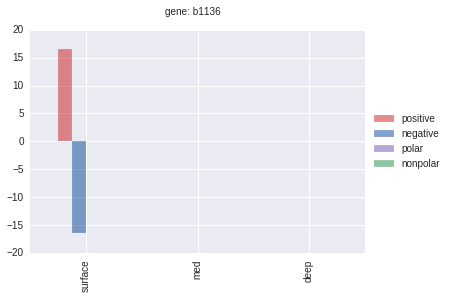

In [296]:
describe_mutations_per_gene(DF_PROPERTIES_merged_RD[DF_PROPERTIES_merged_RD.gene=='b1136'])

In this example, both isocitrate dehydrogenase mutations occur at the surface of the protein. In K12, they are both negatively charged and in wild-type proteins, they are mainly positively charged.. is this what you expect? Lets check back at the original df:

In [299]:
DF_PROPERTIES_merged_RD[DF_PROPERTIES_merged_RD.gene=='b1136'][['gene','res','ca_res_depth','positive','negative']]

,gene,res,ca_res_depth,positive,negative
266,b1136,398,1.99961,0,0
267,b1136,414,1.99956,33,-33


In this case, residue 398 doesnt have a change in charge, but residue 414 is as we expect (negative to positive)

To plot more than one gene:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6 FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7 FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8 FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


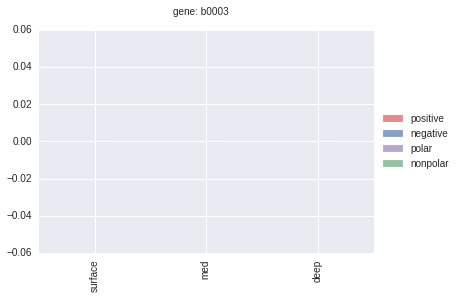

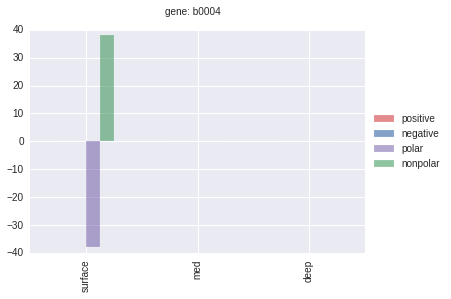

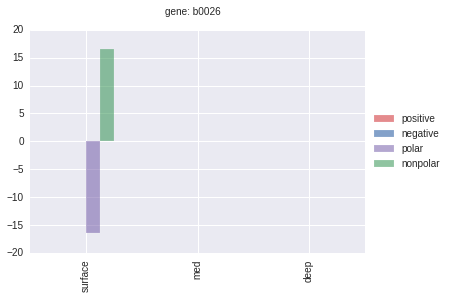

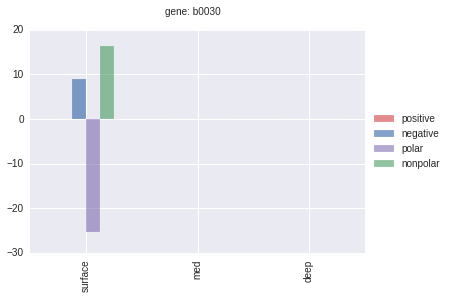

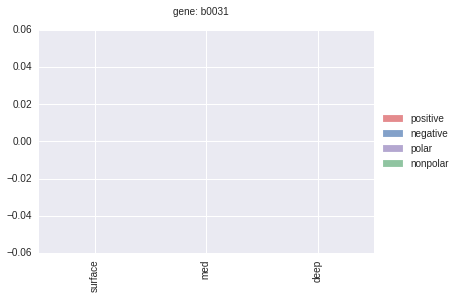

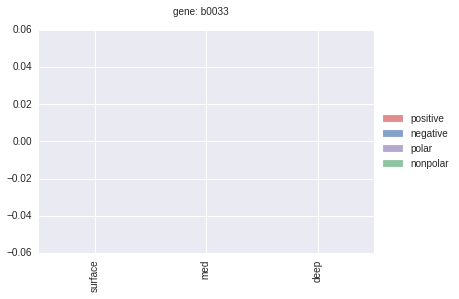

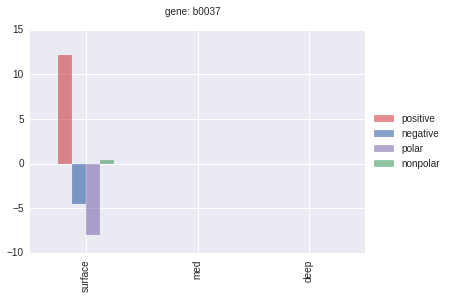

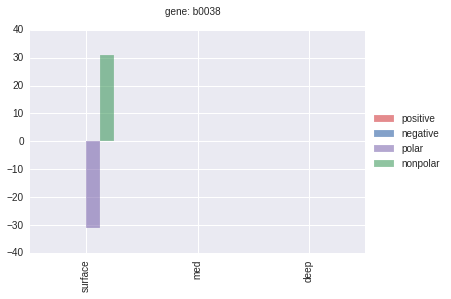

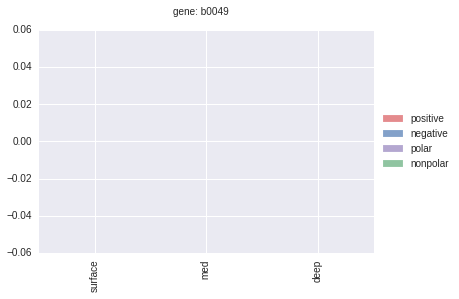

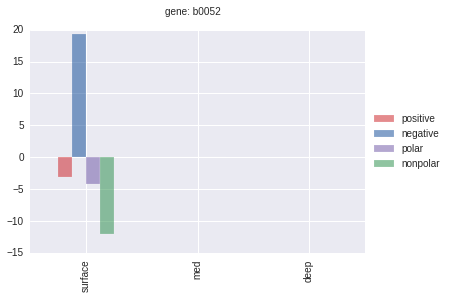

In [300]:
for gene in DF_PROPERTIES_merged_RD.gene.unique()[0:10]:
    describe_mutations_per_gene(DF_PROPERTIES_merged_RD[DF_PROPERTIES_merged_RD.gene==gene])

------------------

# Question #5 & 6 [optional] 

Hint: you have the GEM-PRO, so in case there are PDB structures with ligands bound, you can search in this way

In [302]:
DF_GEM_PRO_EC[pd.notnull(DF_GEM_PRO_EC.p_chemicals)][['m_gene','u_pdb','p_chemicals']].drop_duplicates().head(3)

,m_gene,u_pdb,p_chemicals
812,b0929,3FYX,"['EPE', '451']"
1354,b0929,1GFN,['C8E']
1625,b0929,1GFO,['C8E']


You can use tools like biopython and prody or visualization programs (like VMD or pymol) to understand which residues interact with the ligands bound to these structures

Once you find some interesting changes, you can search through literature to investigate the roles of these residues in enzyme activity